In [1]:
# install the required packages
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# 1. Import the required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

In [3]:
# 2. Load dataset
file_path = "dataset.csv"
df = pd.read_csv(file_path)

In [4]:
# 3. Drop 'CustomerID' as it is not predictive
if "CustomerID" in df.columns:
    df = df.drop(columns=["CustomerID"])

In [5]:
# 4. Convert specified columns to numeric, setting invalid parsing to NaN
numeric_columns = [
    "Tenure", 
    "WarehouseToHome", 
    "HourSpendOnApp",
    "OrderAmountHikeFromlastYear", 
    "OrderCount", 
    "DaySinceLastOrder", 
    "CashbackAmount", 
    "CouponUsed",
    "NumberOfDeviceRegistered", 
    "NumberOfAddress",
    "SatisfactionScore",
    "Complain",
    "CityTier"
]

for col in numeric_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

In [6]:
# 5. Replace zeros with NaN in selected columns
cols_to_replace_zeros = ["CashbackAmount", "CouponUsed"]
for col in cols_to_replace_zeros:
    if col in df.columns:
        df[col] = df[col].replace(0, np.nan)

In [7]:
# 6. Identify numeric and categorical columns
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
categorical_cols = df.select_dtypes(exclude=['number']).columns.tolist()

In [8]:
# 7. Fill missing values
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

In [9]:
# 8. Drop columns with zero variance (all values the same)
zero_variance_cols = [col for col in numeric_cols if df[col].nunique() == 1]
df.drop(columns=zero_variance_cols, inplace=True)
print("Dropped zero-variance columns:", zero_variance_cols)

Dropped zero-variance columns: []


In [10]:
# 9. (a) Calculate mean, median, and standard deviation
numeric_cols = df.select_dtypes(include=['number'])
stats = numeric_cols.describe().T
stats["median"] = numeric_cols.median()
print("\nSummary Statistics:")
print(stats)


Summary Statistics:
                              count        mean        std   min    25%  \
Churn                        5630.0    0.168384   0.374240   0.0    0.0   
Tenure                       5630.0   10.134103   8.357951   0.0    3.0   
CityTier                     5630.0    1.654707   0.915389   1.0    1.0   
WarehouseToHome              5630.0   15.566785   8.345961   5.0    9.0   
HourSpendOnApp               5630.0    2.934636   0.705528   0.0    2.0   
NumberOfDeviceRegistered     5630.0    3.688988   1.023999   1.0    3.0   
SatisfactionScore            5630.0    3.066785   1.380194   1.0    2.0   
NumberOfAddress              5630.0    4.214032   2.583586   1.0    2.0   
Complain                     5630.0    0.284902   0.451408   0.0    0.0   
OrderAmountHikeFromlastYear  5630.0   15.674600   3.591058  11.0   13.0   
CouponUsed                   5630.0    2.128242   1.654433   1.0    1.0   
OrderCount                   5630.0    2.961812   2.879248   1.0    1.0   
DayS

In [11]:
# 10. Select relevant features for further analysis
selected_features = [
    "Churn", "Tenure", "CityTier", "HourSpendOnApp",
    "SatisfactionScore", "OrderCount", "DaySinceLastOrder",
    "CashbackAmount", "WarehouseToHome", "Complain",
    "NumberOfDeviceRegistered", "OrderAmountHikeFromlastYear",
    "CouponUsed", "NumberOfAddress"
]

selected_features = [col for col in selected_features if col in df.columns]
df_filtered = df[selected_features]

In [12]:
# 11. Standardize the selected features
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_filtered), columns=selected_features)

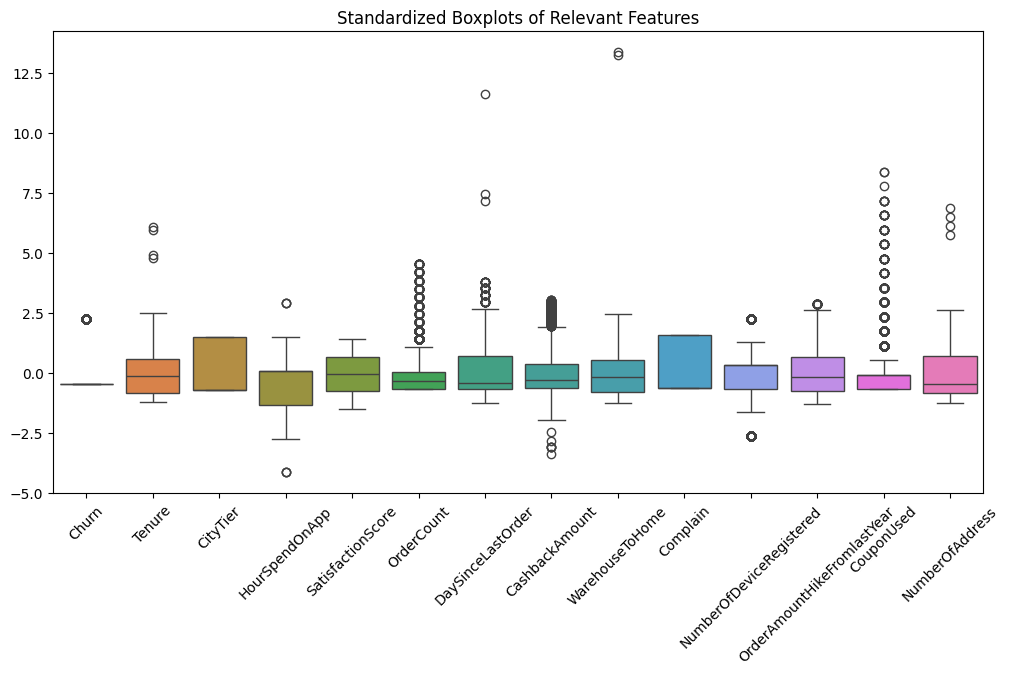

In [13]:
# 12. (b) Plot the boxplots for standardized features
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_scaled)
plt.xticks(rotation=45)
plt.title("Standardized Boxplots of Relevant Features")
plt.show()

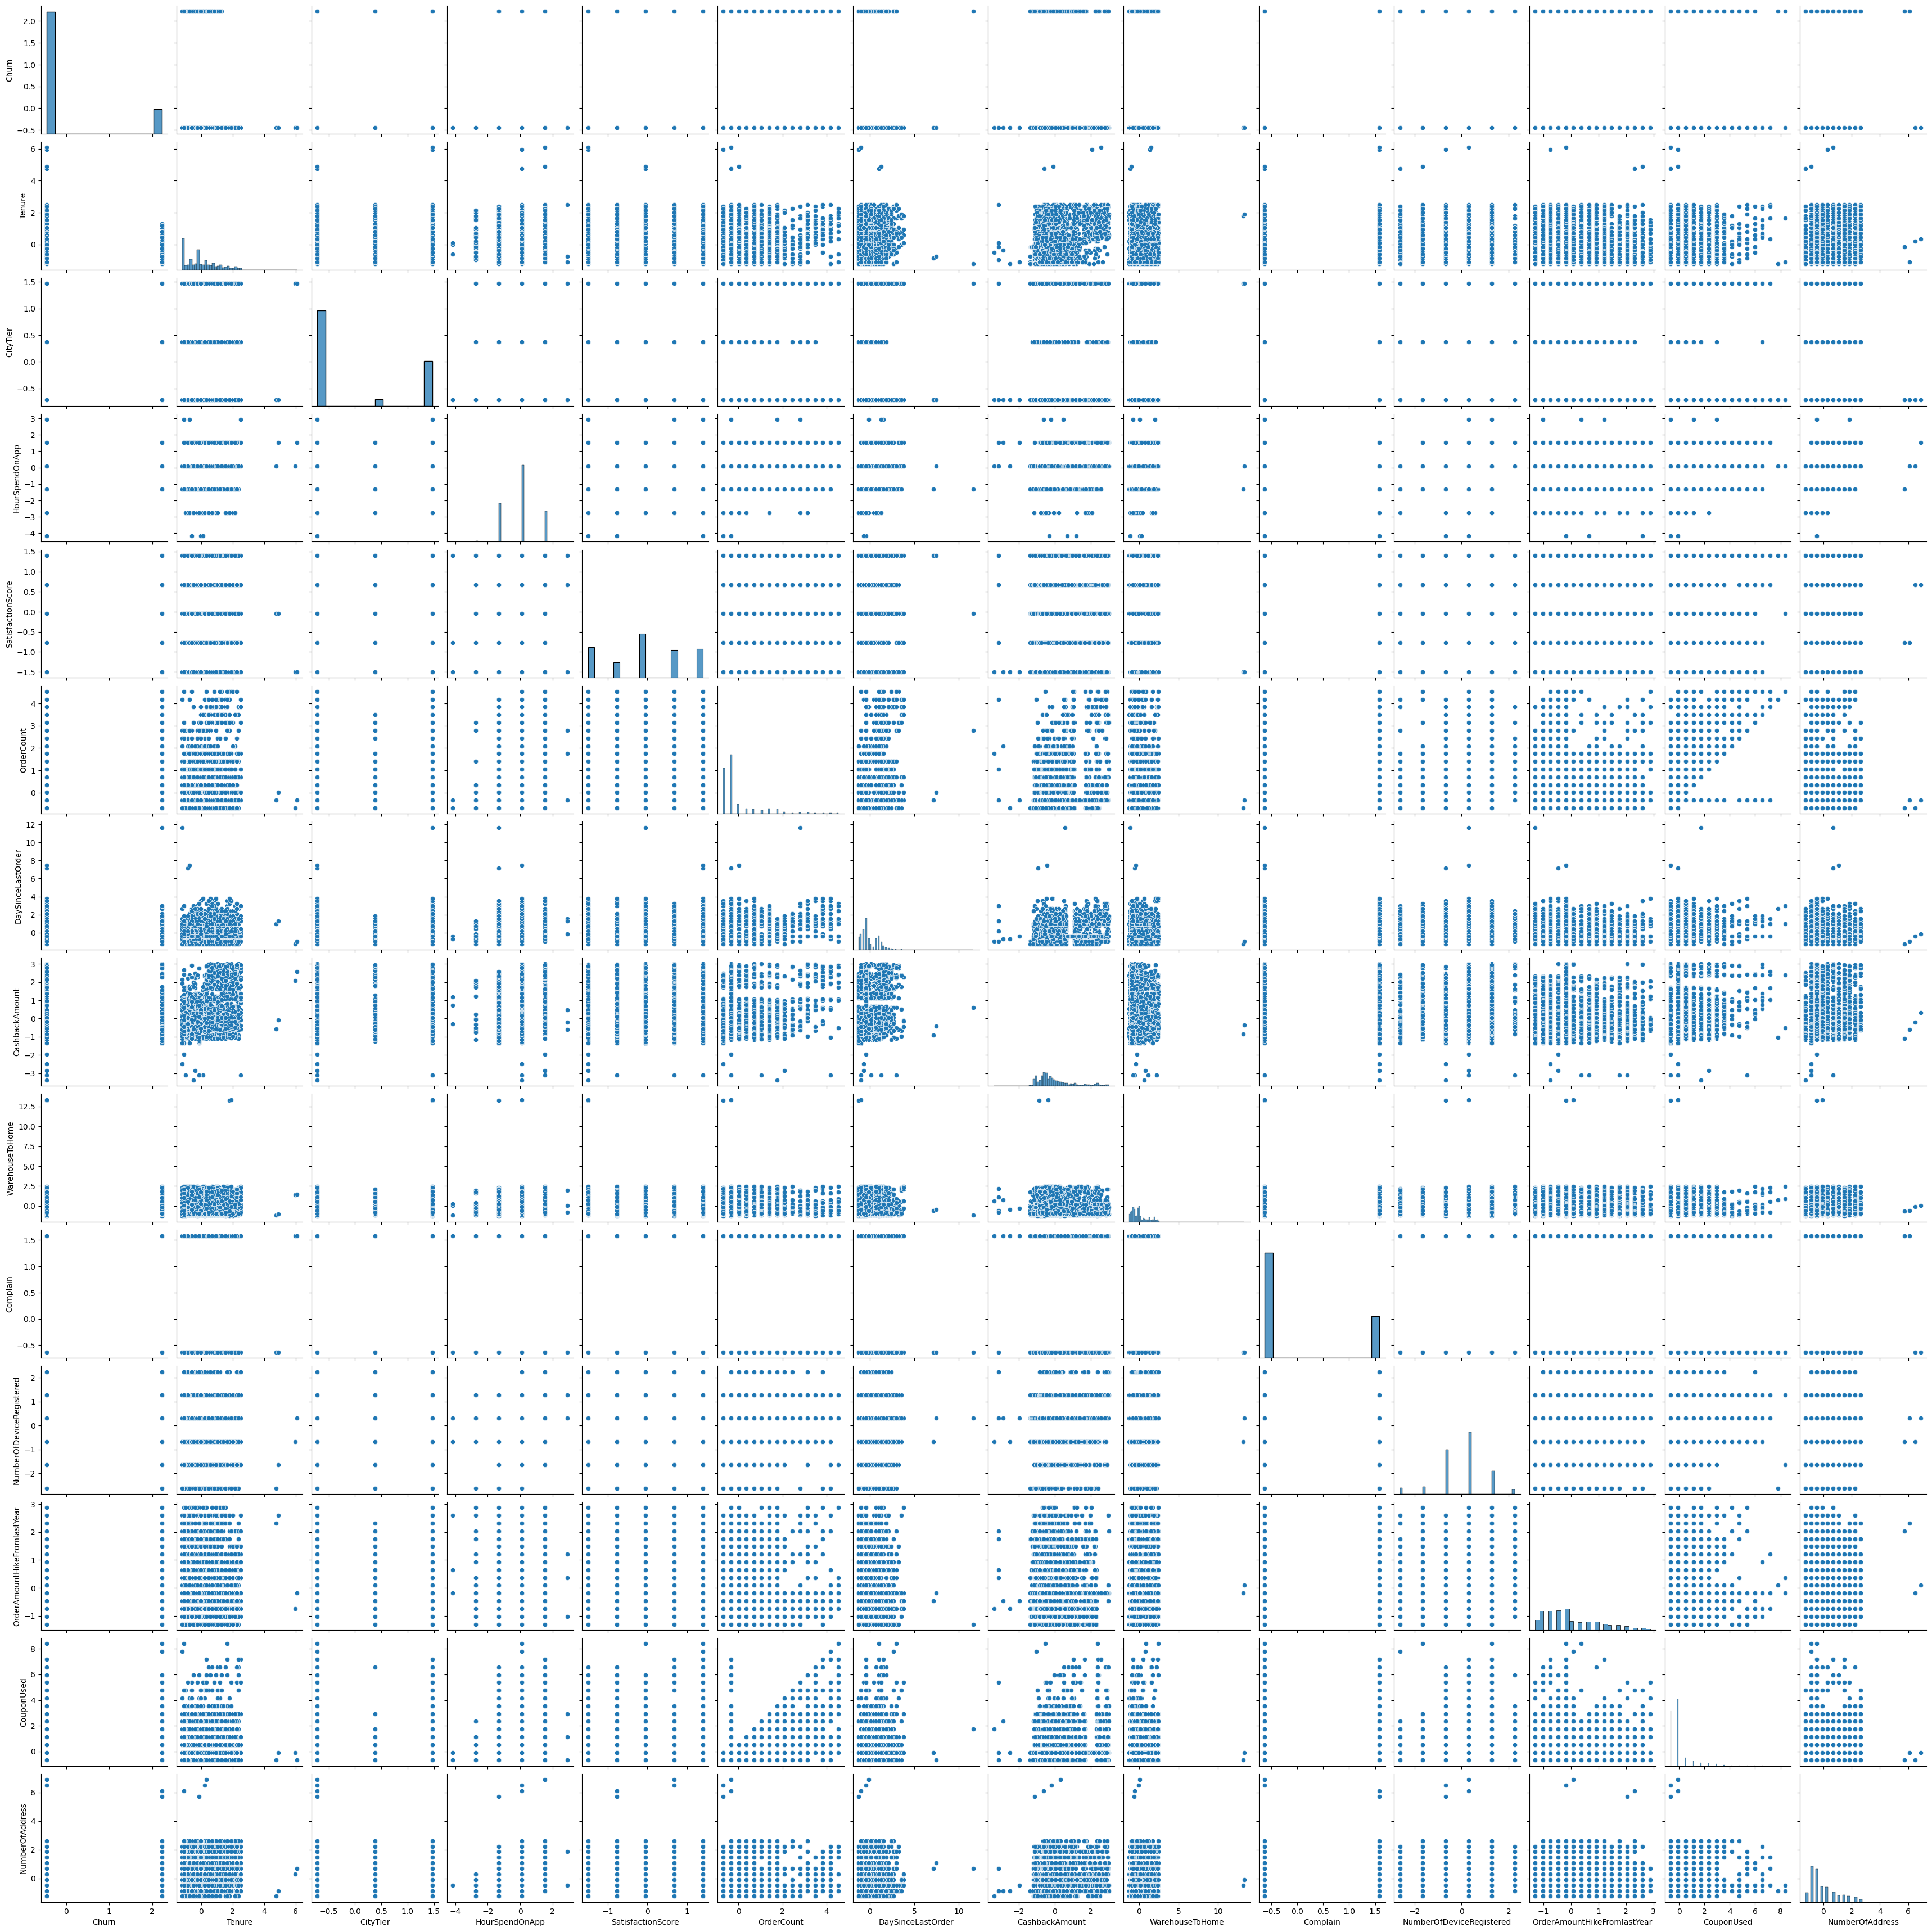

In [14]:
# 13. (c) Draw pairplots for the standardized features
sns.pairplot(df_scaled)
plt.show()

### Findings: Columns for Regression, Classification, and Clustering

**Regression:**
We can predict the following column values using regression:

| Column                      | Description                              |
|-----------------------------|------------------------------------------|
| WarehouseToHome             | Distance (e.g., kilometers/miles)        |
| HourSpendOnApp              | Time spent (e.g., hours)                 |
| OrderAmountHikeFromlastYear | Percentage increase (e.g., 15.5%)        |
| CashbackAmount              | Monetary value (e.g., $25.30)            |
| Tenure                      | Duration (e.g., 6.5 months)              |
| DaySinceLastOrder           | Continuous measure (e.g., 30.5 days)     |

**Classification:**
We can perform classification on the below columns:

| Column                     | Description                                       |
|----------------------------|---------------------------------------------------|
| Churn (target variable)    | Predict if a user churns or not                   |
| PreferredLoginDevice       | Preferred login device of customer                |
| PreferredPaymentMode       | Preferred payment method of customer              |
| PreferedOrderCat           | Preferred order category of customer in last month|
| MaritalStatus              | Marital status of customer                        |
| SatisfactionScore          | Satisfactory score of customer on service         |
| NumberOfDeviceRegistered   | Number of devices (e.g., 2 devices)               |
| NumberOfAddress            | Number of addresses (e.g., 3 addresses)           |
| CouponUsed                 | Number of coupons used (e.g., 5 coupons)          |
| OrderCount                 | Number of orders (e.g., 10 orders)                |
| Complain                   | 0 (No) / 1 (Yes)                                  |

**Clustering:**
Group using features: All continuous + encoded categorical/discrete columns

Group customers based on Tenure, CityTier, and CashbackAmount.

## Key Learnings and Difficulties

##### What Did We Learn from These Steps?

This assignment emphasized the importance of thorough data cleaning and understanding data distributions.
- Handling missing values required careful consideration of appropriate imputation methods.
- Visualizations revealed challenges in interpreting boxplots with limited data points.
- Difficulties included determining appropriate features for zero replacement and managing overlapping visualizations.
- The exercise highlighted that EDA is a repetitive process and showed how important it is to understand the subject area when cleaning and preparing data.


The columns showing the highest correlation with the target variable (Churn) are:
- Tenure
- OrderCount
- HourSpendOnApp

These columns can be used to build predictive models for customer churn. High correlation indicates that changes in these features are strongly associated with changes in the target variable. For instance, Tenure can help identify long-term customers who are less likely to churn, while Orderount and HourSpendOnApp can provide insights into customer engagement and purchasing behavior.


### End of Project_Part_2

### Begining of Project_Part_3

In [15]:
#Calculate Pearson's correlation with 'Churn'
correlations = {}
for col in df.select_dtypes(include=['number']).columns:
    if col != "Churn":
        corr, _ = pearsonr(df[col], df["Churn"])
        correlations[col] = corr
        print(f"Pearson correlation between {col} and Churn: {corr:.3f}")

Pearson correlation between Tenure and Churn: -0.338
Pearson correlation between CityTier and Churn: 0.085
Pearson correlation between WarehouseToHome and Churn: 0.070
Pearson correlation between HourSpendOnApp and Churn: 0.019
Pearson correlation between NumberOfDeviceRegistered and Churn: 0.108
Pearson correlation between SatisfactionScore and Churn: 0.105
Pearson correlation between NumberOfAddress and Churn: 0.044
Pearson correlation between Complain and Churn: 0.250
Pearson correlation between OrderAmountHikeFromlastYear and Churn: -0.007
Pearson correlation between CouponUsed and Churn: -0.004
Pearson correlation between OrderCount and Churn: -0.024
Pearson correlation between DaySinceLastOrder and Churn: -0.156
Pearson correlation between CashbackAmount and Churn: -0.156


----- Univariate Random Forest Regression -----
Tenure: Test R² = 0.236, Pearson² = 0.114


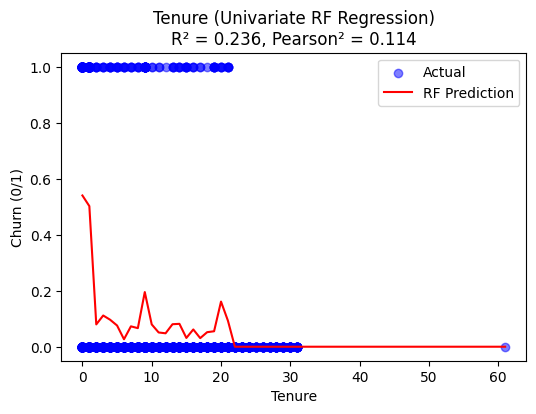

CityTier: Test R² = 0.001, Pearson² = 0.007


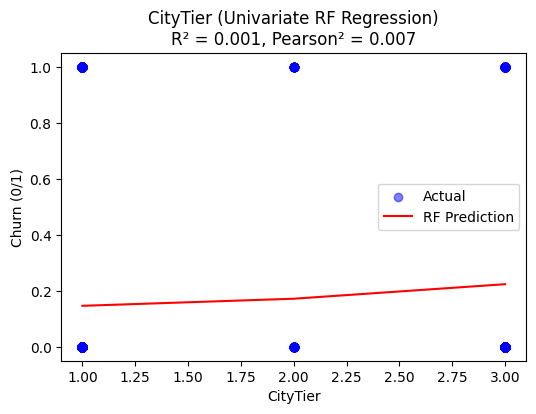

HourSpendOnApp: Test R² = 0.001, Pearson² = 0.000


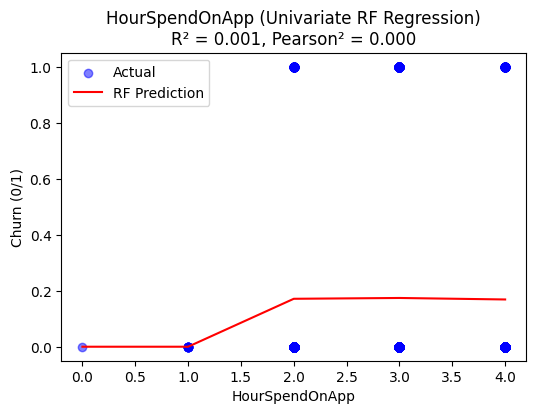

SatisfactionScore: Test R² = 0.015, Pearson² = 0.011


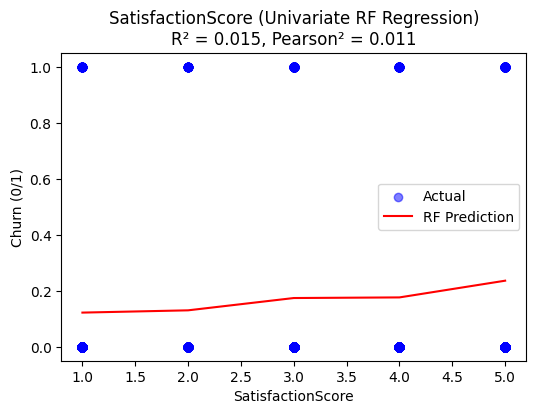

OrderCount: Test R² = -0.004, Pearson² = 0.001


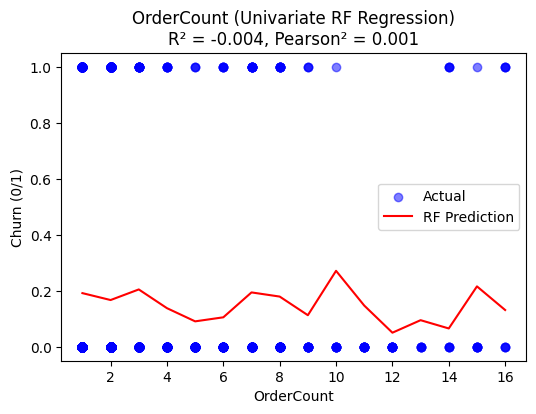

DaySinceLastOrder: Test R² = 0.025, Pearson² = 0.024


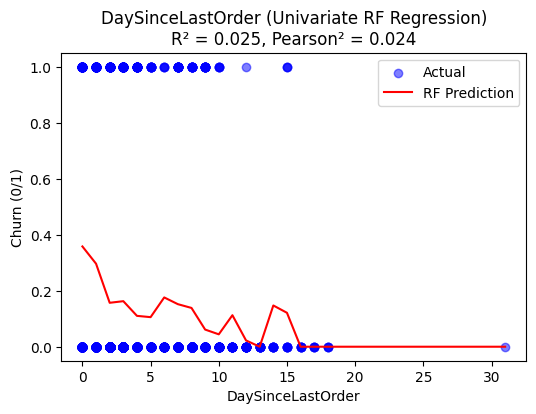

CashbackAmount: Test R² = 0.013, Pearson² = 0.024


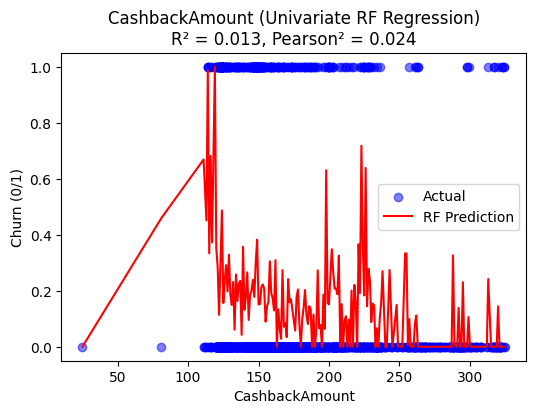

WarehouseToHome: Test R² = 0.006, Pearson² = 0.005


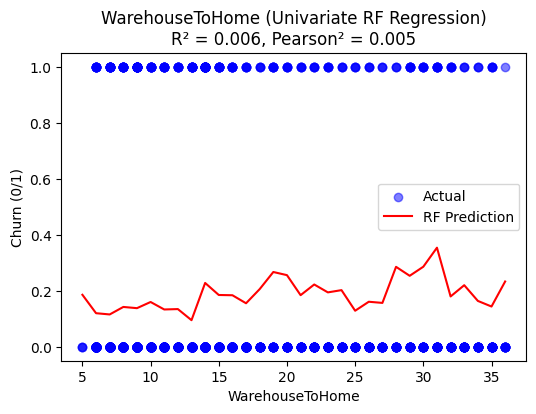

Complain: Test R² = 0.054, Pearson² = 0.063


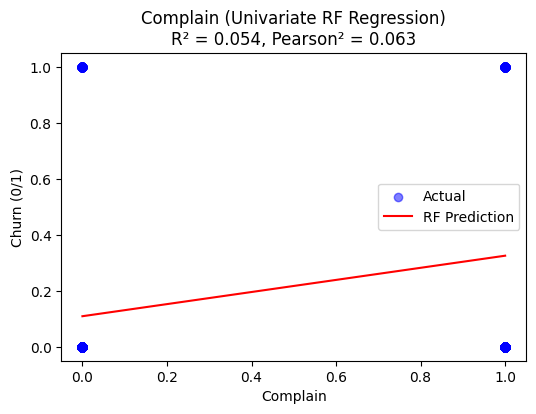

NumberOfDeviceRegistered: Test R² = 0.016, Pearson² = 0.012


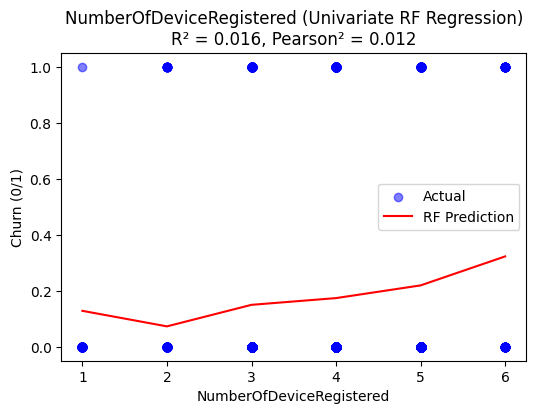

OrderAmountHikeFromlastYear: Test R² = 0.007, Pearson² = 0.000


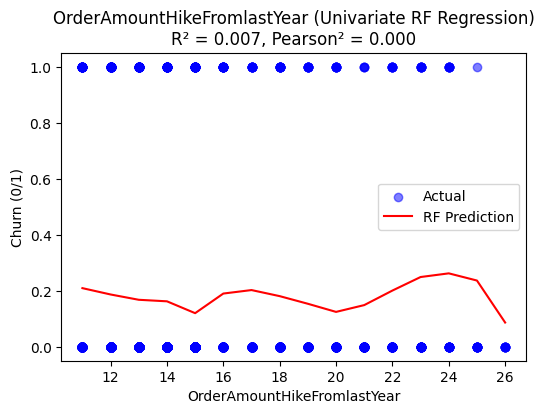

CouponUsed: Test R² = -0.004, Pearson² = 0.000


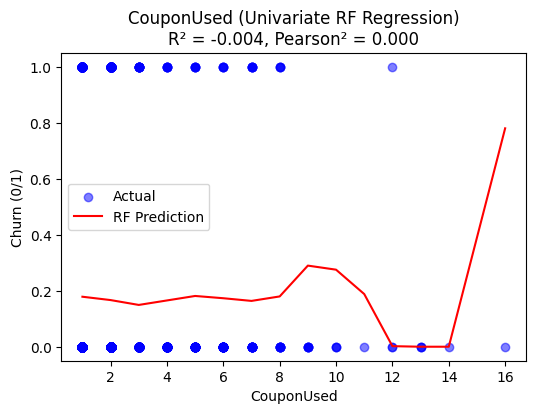

NumberOfAddress: Test R² = 0.013, Pearson² = 0.002


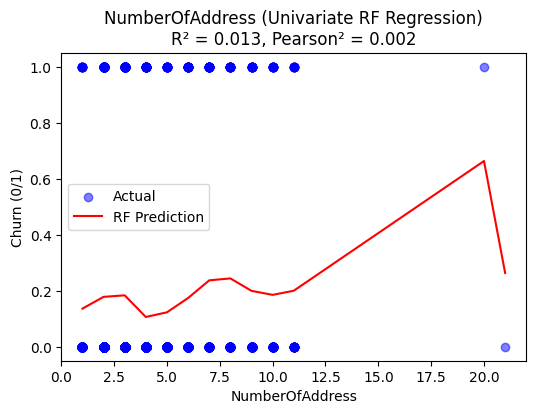

In [16]:
numeric_features = [col for col in df_filtered.select_dtypes(include=['number']).columns if col != "Churn"]

print("----- Univariate Random Forest Regression -----")
for col in numeric_features:
    X = df_filtered[[col]]
    y = df_filtered["Churn"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_reg.fit(X_train, y_train)

    y_pred = rf_reg.predict(X_test)
    r2 = r2_score(y_test, y_pred)

    r, _ = pearsonr(df_filtered[col], df_filtered["Churn"])
    pearson_sq = r ** 2

    print(f"{col}: Test R² = {r2:.3f}, Pearson² = {pearson_sq:.3f}")

    plt.figure(figsize=(6,4))
    plt.scatter(X_test, y_test, color='blue', alpha=0.5, label="Actual")

    sorted_idx = np.argsort(X_test[col].values.flatten())
    plt.plot(X_test[col].values.flatten()[sorted_idx],
            y_pred[sorted_idx],
            color="red",
            label="RF Prediction")
    plt.xlabel(col)
    plt.ylabel("Churn (0/1)")
    plt.title(f"{col} (Univariate RF Regression)\nR² = {r2:.3f}, Pearson² = {pearson_sq:.3f}")
    plt.legend()
    plt.show()


Multivariate RF Regression: Test R² = 0.715


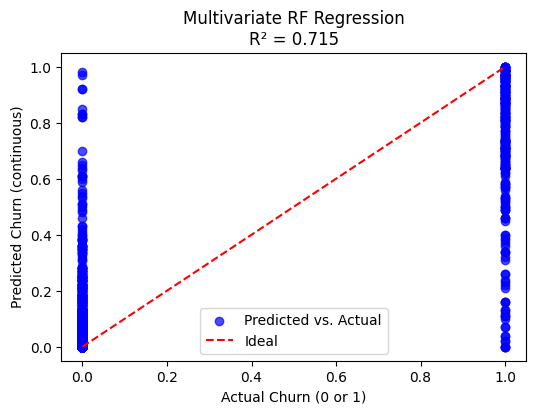

In [17]:
multivariate_predictors = [col for col in df_filtered.columns if col != "Churn"]

X_multi = df_filtered[multivariate_predictors]
y_multi = df_filtered["Churn"]

X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_multi, y_multi, test_size=0.3, random_state=42)

rf_reg_multi = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg_multi.fit(X_train_m, y_train_m)

y_pred_m = rf_reg_multi.predict(X_test_m)
r2_multi = r2_score(y_test_m, y_pred_m)
print(f"\nMultivariate RF Regression: Test R² = {r2_multi:.3f}")

plt.figure(figsize=(6,4))
plt.scatter(y_test_m, y_pred_m, alpha=0.7, color='blue', label="Predicted vs. Actual")
plt.xlabel("Actual Churn (0 or 1)")
plt.ylabel("Predicted Churn (continuous)")
plt.title(f"Multivariate RF Regression\nR² = {r2_multi:.3f}")

plt.plot([0,1], [0,1], color='red', linestyle='--', label="Ideal")
plt.legend()
plt.show()

In [18]:
X_clf = df_filtered[multivariate_predictors]
y_clf = df_filtered["Churn"]

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_clf, y_clf, test_size=0.3, random_state=42)

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_c, y_train_c)

y_pred_c = rf_clf.predict(X_test_c)
y_pred_prob_c = rf_clf.predict_proba(X_test_c)[:, 1]

accuracy = accuracy_score(y_test_c, y_pred_c)
roc_auc = roc_auc_score(y_test_c, y_pred_prob_c)
print(f"Multivariate RF Classification -- Accuracy: {accuracy:.3f}, ROC AUC: {roc_auc:.3f}")

Multivariate RF Classification -- Accuracy: 0.960, ROC AUC: 0.971


### Key Learnings from Project Part 3


#### In Project Part 3, we focused on understanding the correlation between features and the target variable, Churn. We learned that features like Tenure, OrderCount, and HourSpendOnApp have significant correlations with Churn, which can be leveraged to build predictive models.

#### We also plotted scatterplots for each column to predict churn and found that multiple feature's values help in predicting churn effectively. This multivariate approach provided a more accurate prediction model compared to univariate models. The RandomForestClassifier and RandomForestRegressor were instrumental in achieving high accuracy and R² scores.

### End of Project_Part_3

In [ ]:
# Import additional required libraries
from sklearn.cluster import AgglomerativeClustering, KMeans, MiniBatchKMeans, MeanShift, estimate_bandwidth
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, classification_report
from scipy.cluster.hierarchy import dendrogram, linkage

print("\n" + "="*50)
print("CLUSTERING ANALYSIS")
print("="*50)


CLUSTERING ANALYSIS


In [20]:
# Use the features without the target variable for clustering
X_cluster = df_filtered.drop(columns=['Churn'])

# Standardize the data for clustering if not already done
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# For visualization, reduce to 2 dimensions using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print(f"Explained variance by first two PCA components: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.2f}")

Explained variance by first two PCA components: [0.17906357 0.10859986]
Total variance explained: 0.29


In [21]:
# Function to evaluate clustering results
def evaluate_clustering(X_data, X_pca, model, model_name):
    # Apply clustering
    clusters = model.fit_predict(X_data)
    
    # Determine number of clusters
    if hasattr(model, 'cluster_centers_'):
        n_clusters = len(model.cluster_centers_)
    else:
        n_clusters = len(np.unique(clusters))
    
    # Calculate silhouette score if more than one cluster
    if n_clusters > 1:
        sil_score = silhouette_score(X_data, clusters)
        print(f"{model_name} Silhouette Score: {sil_score:.3f}")
    else:
        sil_score = np.nan
        print(f"{model_name} created only one cluster, silhouette score not applicable")
    
    # Visualize clusters
    plt.figure(figsize=(12, 5))
    
    # PCA plot with clusters
    plt.subplot(1, 2, 1)
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', 
                          alpha=0.7, s=50)
    plt.colorbar(scatter, label='Cluster')
    plt.title(f'{model_name} Clustering (n={n_clusters})')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.grid(alpha=0.3)
    
    # Churn rate by cluster
    plt.subplot(1, 2, 2)
    cluster_df = pd.DataFrame({'Cluster': clusters, 'Churn': df_filtered['Churn']})
    churn_by_cluster = cluster_df.groupby('Cluster')['Churn'].mean().reset_index()
    sns.barplot(x='Cluster', y='Churn', data=churn_by_cluster)
    plt.title('Average Churn Rate by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Churn Rate')
    plt.ylim(0, 1)
    
    plt.tight_layout()
    plt.show()
    
    return clusters, sil_score, n_clusters


1. Agglomerative Clustering


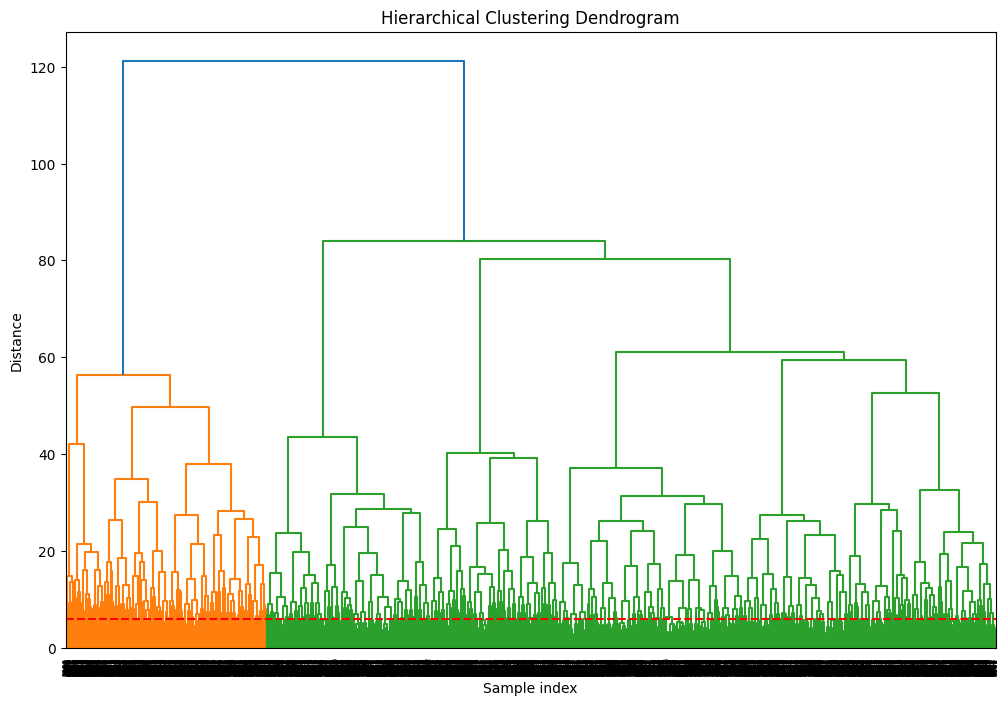

In [22]:
# 1. Agglomerative Clustering
print("\n1. Agglomerative Clustering")
# Visualize dendrogram to determine optimal clusters
plt.figure(figsize=(12, 8))
dendrogram_plot = dendrogram(linkage(X_scaled, method='ward'))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.axhline(y=6, color='r', linestyle='--')  # Adjust threshold as needed
plt.show()

Agglomerative Silhouette Score: 0.071


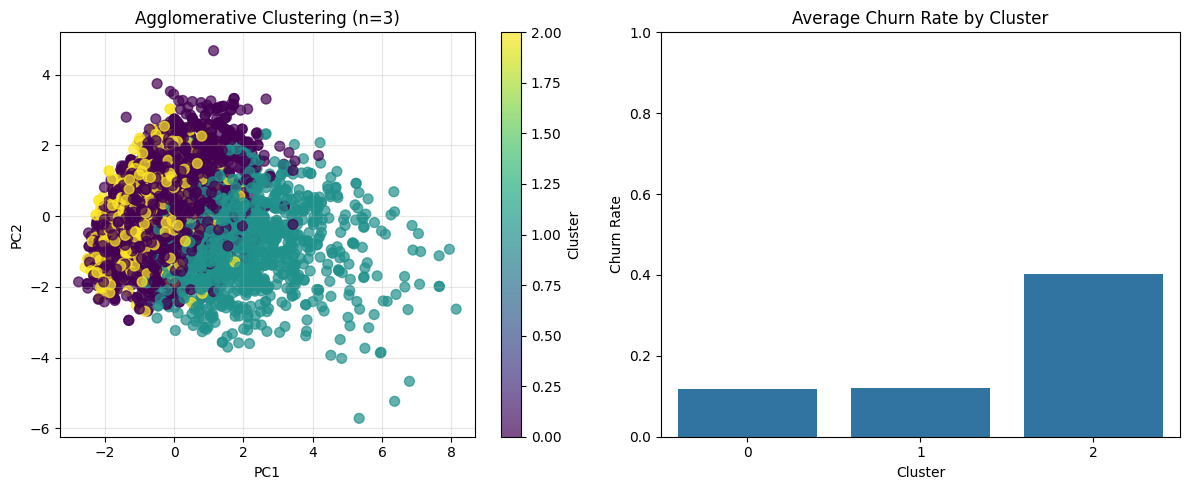

In [23]:
# Using 3 clusters based on dendrogram
agg_model = AgglomerativeClustering(n_clusters=3)
agg_clusters, agg_silhouette, agg_n_clusters = evaluate_clustering(X_scaled, X_pca, agg_model, "Agglomerative")


2. K-Means Clustering


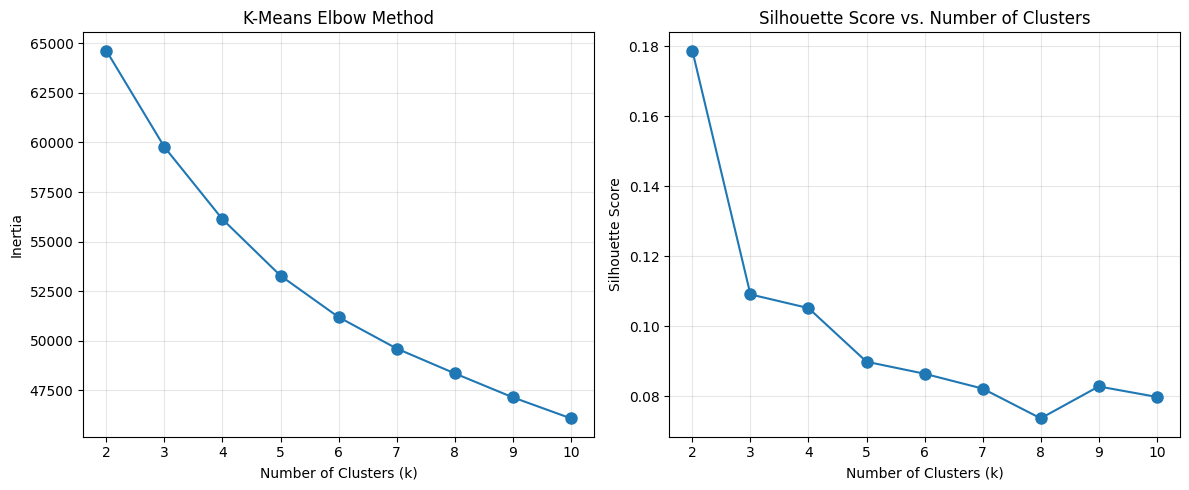

In [24]:
# 2. K-Means Clustering
print("\n2. K-Means Clustering")
# Determine optimal k using elbow method
inertia = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot elbow curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, 'o-', markersize=8)
plt.title('K-Means Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'o-', markersize=8)
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

K-Means Silhouette Score: 0.109


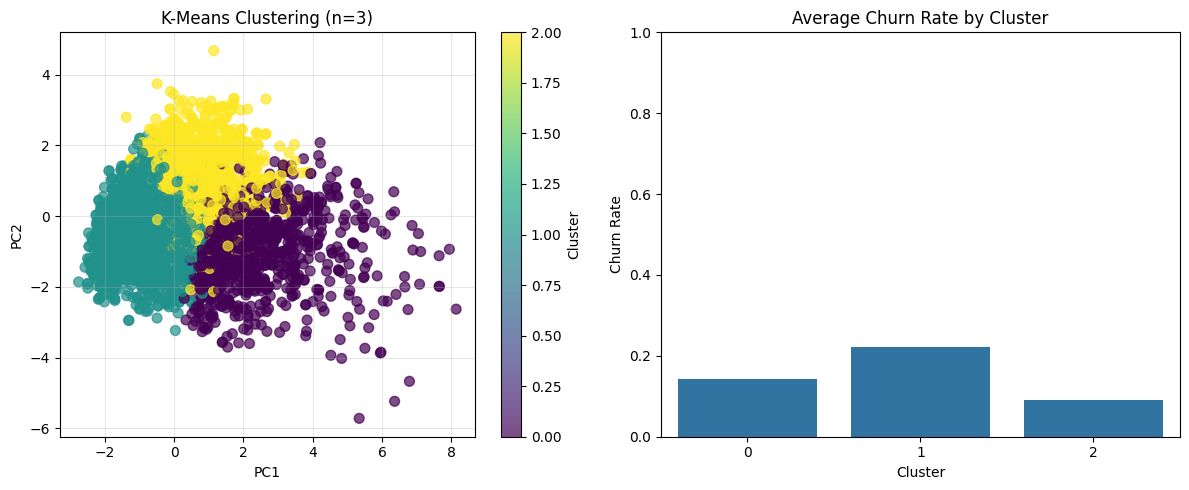


3. Mini-Batch K-Means Clustering
Mini-Batch K-Means Silhouette Score: 0.114


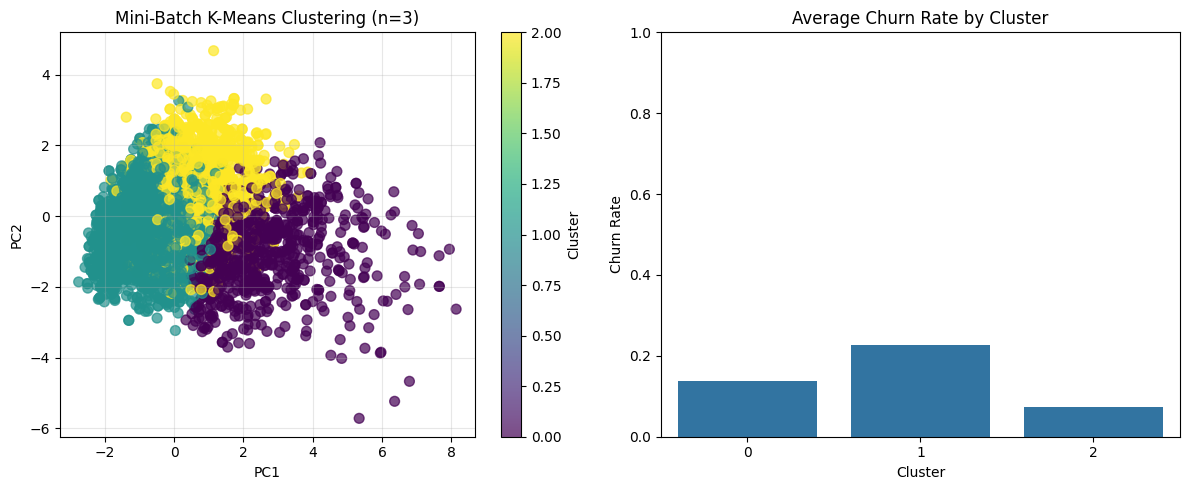

In [25]:
# Choose optimal k based on plots
optimal_k = 3  
kmeans_model = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_clusters, kmeans_silhouette, kmeans_n_clusters = evaluate_clustering(X_scaled, X_pca, kmeans_model, "K-Means")

# 3. Mini-Batch K-Means
print("\n3. Mini-Batch K-Means Clustering")
mbkmeans_model = MiniBatchKMeans(n_clusters=optimal_k, random_state=42, batch_size=256, n_init=10)
mbkmeans_clusters, mbkmeans_silhouette, mbkmeans_n_clusters = evaluate_clustering(X_scaled, X_pca, mbkmeans_model, "Mini-Batch K-Means")


4. Mean Shift Clustering
Mean Shift Silhouette Score: 0.299


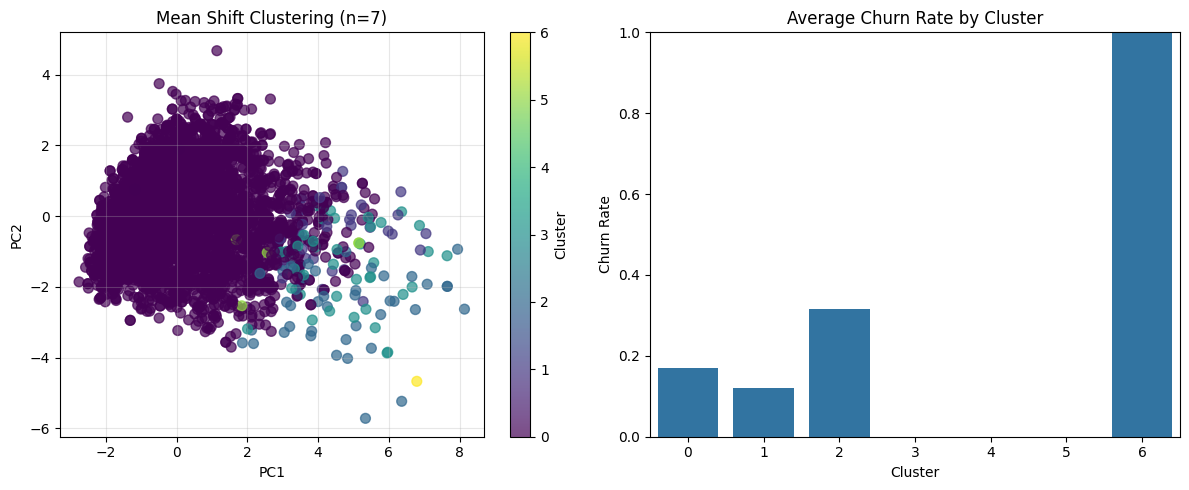

In [26]:
# 4. Mean Shift Clustering
print("\n4. Mean Shift Clustering")
# Estimate bandwidth
bandwidth = estimate_bandwidth(X_scaled, quantile=0.2, n_samples=500)
ms_model = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms_clusters, ms_silhouette, ms_n_clusters = evaluate_clustering(X_scaled, X_pca, ms_model, "Mean Shift")

In [27]:
# Compare clustering methods
clustering_results = pd.DataFrame({
    'Method': ['Agglomerative', 'K-Means', 'Mini-Batch K-Means', 'Mean Shift'],
    'Number of Clusters': [agg_n_clusters, kmeans_n_clusters, mbkmeans_n_clusters, ms_n_clusters],
    'Silhouette Score': [agg_silhouette, kmeans_silhouette, mbkmeans_silhouette, ms_silhouette]
})

print("\nClustering Methods Comparison:")
print(clustering_results.sort_values('Silhouette Score', ascending=False))


Clustering Methods Comparison:
               Method  Number of Clusters  Silhouette Score
3          Mean Shift                   7          0.299315
2  Mini-Batch K-Means                   3          0.113925
1             K-Means                   3          0.109128
0       Agglomerative                   3          0.070740


In [28]:
# Select best clustering method based on silhouette score
best_clustering = clustering_results.loc[clustering_results['Silhouette Score'].idxmax()]
print(f"\nBest clustering method: {best_clustering['Method']} with {best_clustering['Number of Clusters']} clusters")
print(f"Silhouette score: {best_clustering['Silhouette Score']:.3f}")


Best clustering method: Mean Shift with 7 clusters
Silhouette score: 0.299


In [29]:
# Add cluster assignments from best method to the original data
if best_clustering['Method'] == 'Agglomerative':
    best_clusters = agg_clusters
elif best_clustering['Method'] == 'K-Means':
    best_clusters = kmeans_clusters
elif best_clustering['Method'] == 'Mini-Batch K-Means':
    best_clusters = mbkmeans_clusters
else:
    best_clusters = ms_clusters

In [30]:

# Add clusters to the dataset
df_filtered['Cluster'] = best_clusters

# Analyze cluster characteristics
cluster_churn = df_filtered.groupby('Cluster')['Churn'].agg(['mean', 'count']).reset_index()
cluster_churn.columns = ['Cluster', 'Churn Rate', 'Count']
print("\nChurn Rate by Cluster:")
print(cluster_churn)

print("\n" + "="*50)
print("CLASSIFICATION ANALYSIS")
print("="*50)


Churn Rate by Cluster:
   Cluster  Churn Rate  Count
0        0    0.168937   5505
1        1    0.121212     33
2        2    0.317073     41
3        3    0.000000     42
4        4    0.000000      2
5        5    0.000000      6
6        6    1.000000      1

CLASSIFICATION ANALYSIS


C:\Users\shyam\AppData\Local\Temp\ipykernel_14652\1391861897.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Cluster'] = best_clusters


In [31]:
# Prepare data for classification with and without cluster feature
X_with_cluster = df_filtered.drop(columns=['Churn'])
X_without_cluster = X_with_cluster.drop(columns=['Cluster'])
y = df_filtered['Churn']

In [32]:
# Split the data
X_train_with, X_test_with, y_train, y_test = train_test_split(
    X_with_cluster, y, test_size=0.3, random_state=42)
X_train_without = X_train_with.drop(columns=['Cluster'])
X_test_without = X_test_with.drop(columns=['Cluster'])

In [34]:
# Standardize
scaler_with = StandardScaler()
X_train_with_scaled = scaler_with.fit_transform(X_train_with)
X_test_with_scaled = scaler_with.transform(X_test_with)

scaler_without = StandardScaler()
X_train_without_scaled = scaler_without.fit_transform(X_train_without)
X_test_without_scaled = scaler_without.transform(X_test_without)

In [39]:
from sklearn.metrics import confusion_matrix

# Function to evaluate classifiers
def evaluate_classifier(model, X_train, X_test, y_train, y_test, model_name, 
                        with_cluster=True):
    # Fit model
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Get probabilities if available
    if hasattr(model, "predict_proba"):
        y_pred_prob = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_prob)
    else:
        # Use decision function for SVM if predict_proba not available
        if hasattr(model, "decision_function"):
            y_scores = model.decision_function(X_test)
            roc_auc = roc_auc_score(y_test, y_scores)
        else:
            roc_auc = np.nan
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, output_dict=True)
    
    # Print results
    print(f"\n{model_name} {'with' if with_cluster else 'without'} Cluster Feature:")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"ROC AUC: {roc_auc:.3f}")
    print(f"Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Visualize confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Churned', 'Churned'],
                yticklabels=['Not Churned', 'Churned'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Feature importance if available
    if hasattr(model, 'feature_importances_'):
        features = X_with_cluster.columns if with_cluster else X_without_cluster.columns
        importances = pd.DataFrame({
            'Feature': features,
            'Importance': model.feature_importances_
        }).sort_values('Importance', ascending=False)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=importances.head(10))
        plt.title(f'{model_name} Feature Importance')
        plt.tight_layout()
        plt.show()
    
    return {
        'Model': model_name,
        'With Cluster': with_cluster,
        'Accuracy': accuracy,
        'ROC AUC': roc_auc,
        'F1 (Churned)': class_report['1']['f1-score']
    }

In [40]:
# Initialize all classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Support Vector Machine': SVC(probability=True, random_state=42),
    'Naive Bayes': GaussianNB(),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
}

# Evaluate all classifiers
results = []


Logistic Regression with Cluster Feature:
Accuracy: 0.880
ROC AUC: 0.855
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93      1414
           1       0.75      0.40      0.52       275

    accuracy                           0.88      1689
   macro avg       0.82      0.69      0.72      1689
weighted avg       0.87      0.88      0.86      1689



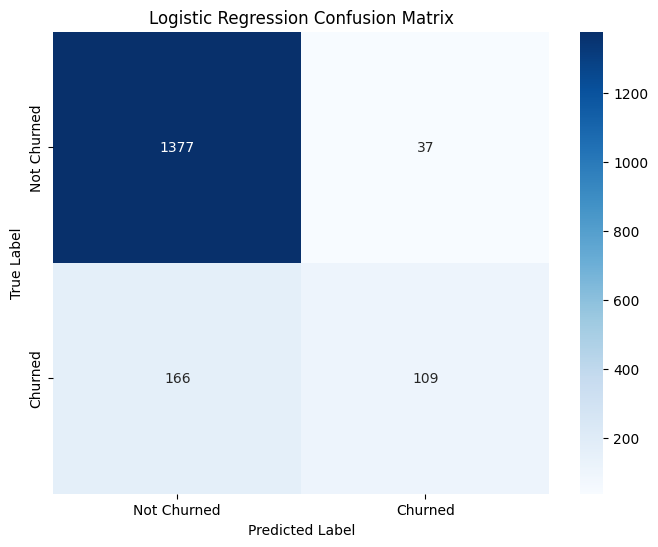


Logistic Regression without Cluster Feature:
Accuracy: 0.879
ROC AUC: 0.854
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93      1414
           1       0.74      0.40      0.52       275

    accuracy                           0.88      1689
   macro avg       0.82      0.68      0.72      1689
weighted avg       0.87      0.88      0.86      1689



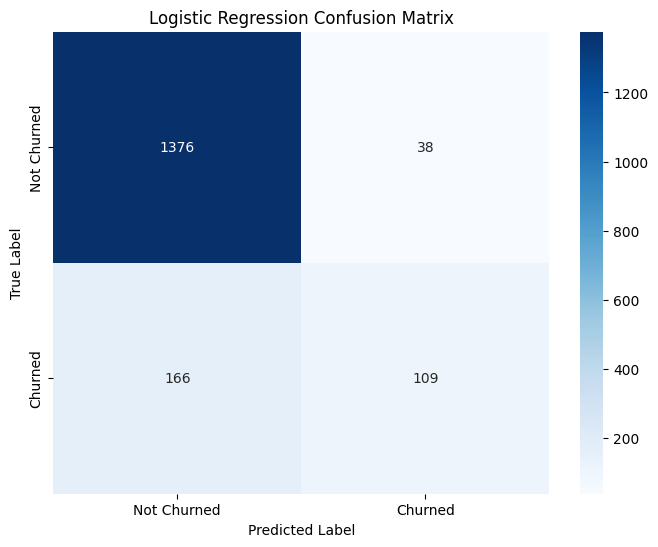


K-Nearest Neighbors with Cluster Feature:
Accuracy: 0.879
ROC AUC: 0.889
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93      1414
           1       0.72      0.43      0.54       275

    accuracy                           0.88      1689
   macro avg       0.81      0.70      0.73      1689
weighted avg       0.87      0.88      0.87      1689



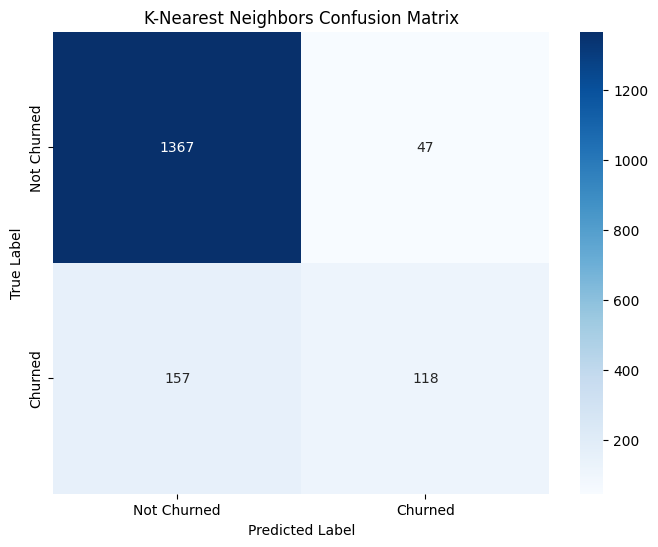


K-Nearest Neighbors without Cluster Feature:
Accuracy: 0.879
ROC AUC: 0.889
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93      1414
           1       0.72      0.43      0.54       275

    accuracy                           0.88      1689
   macro avg       0.81      0.70      0.73      1689
weighted avg       0.87      0.88      0.87      1689



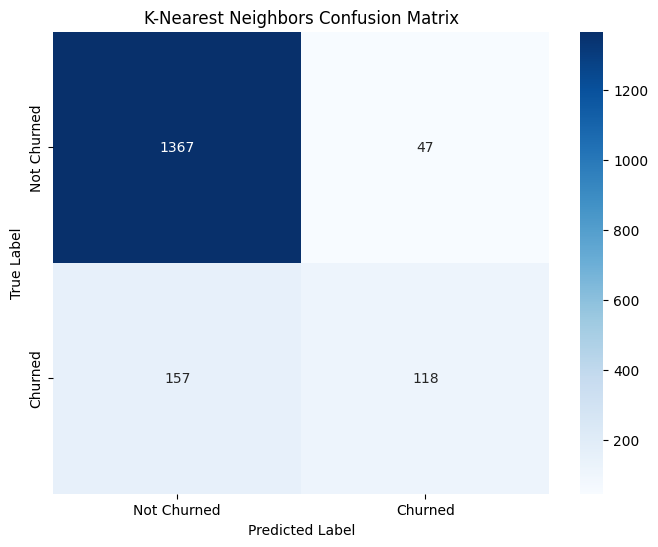


Decision Tree with Cluster Feature:
Accuracy: 0.942
ROC AUC: 0.901
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1414
           1       0.81      0.84      0.82       275

    accuracy                           0.94      1689
   macro avg       0.89      0.90      0.90      1689
weighted avg       0.94      0.94      0.94      1689



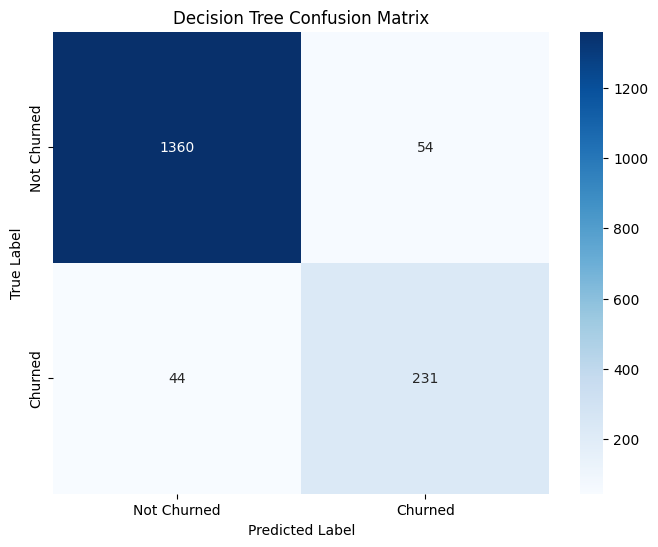

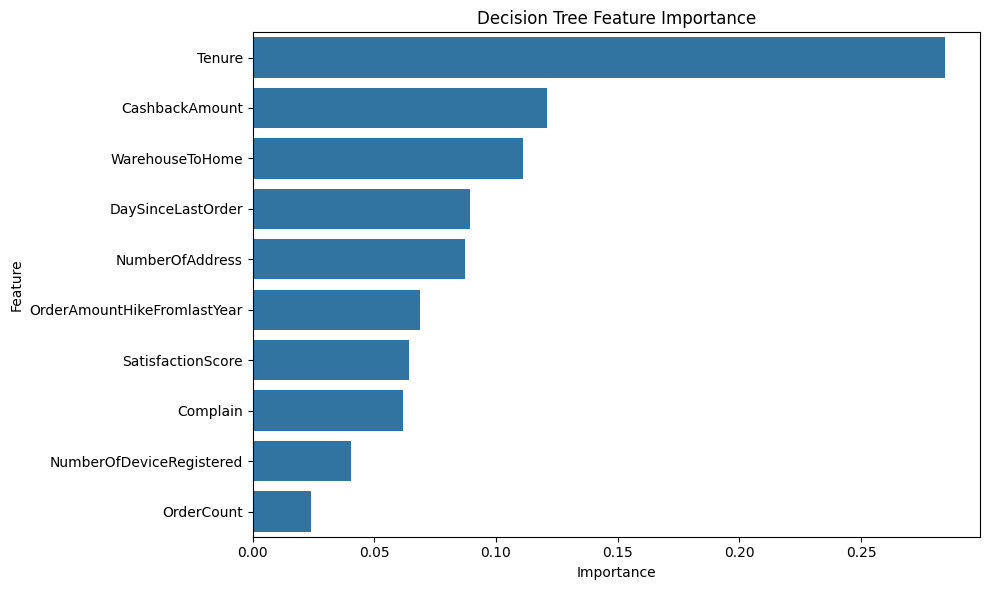


Decision Tree without Cluster Feature:
Accuracy: 0.942
ROC AUC: 0.897
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1414
           1       0.82      0.83      0.82       275

    accuracy                           0.94      1689
   macro avg       0.89      0.90      0.89      1689
weighted avg       0.94      0.94      0.94      1689



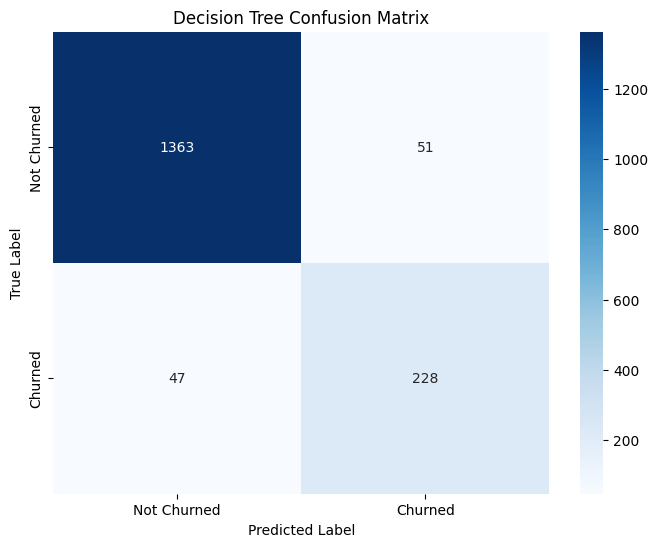

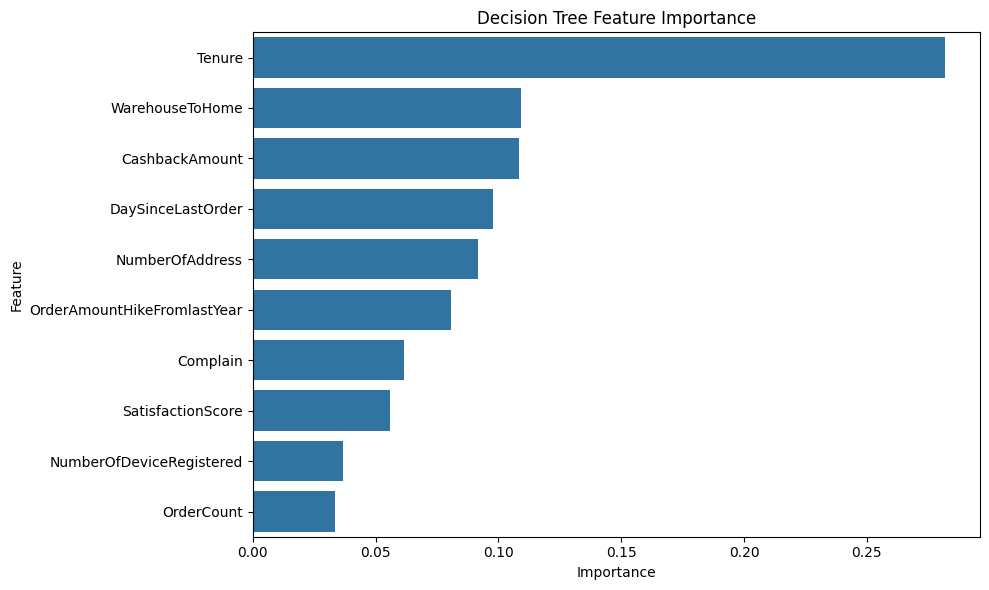


Support Vector Machine with Cluster Feature:
Accuracy: 0.888
ROC AUC: 0.896
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      1414
           1       0.84      0.39      0.53       275

    accuracy                           0.89      1689
   macro avg       0.86      0.69      0.73      1689
weighted avg       0.88      0.89      0.87      1689



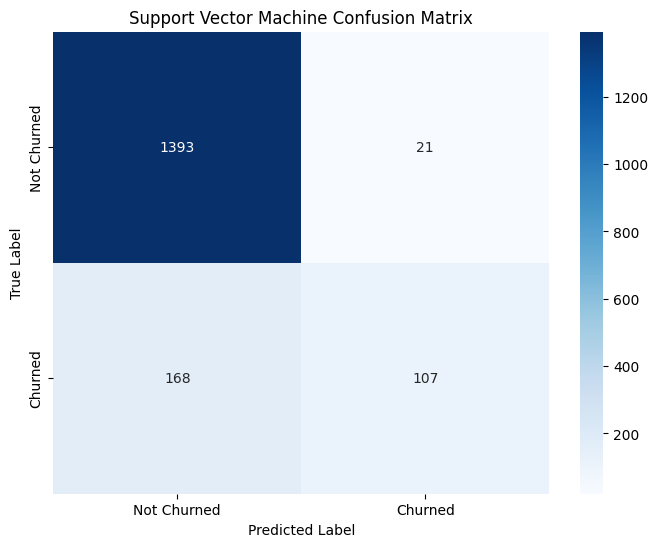


Support Vector Machine without Cluster Feature:
Accuracy: 0.888
ROC AUC: 0.897
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.94      1414
           1       0.83      0.40      0.54       275

    accuracy                           0.89      1689
   macro avg       0.86      0.69      0.74      1689
weighted avg       0.88      0.89      0.87      1689



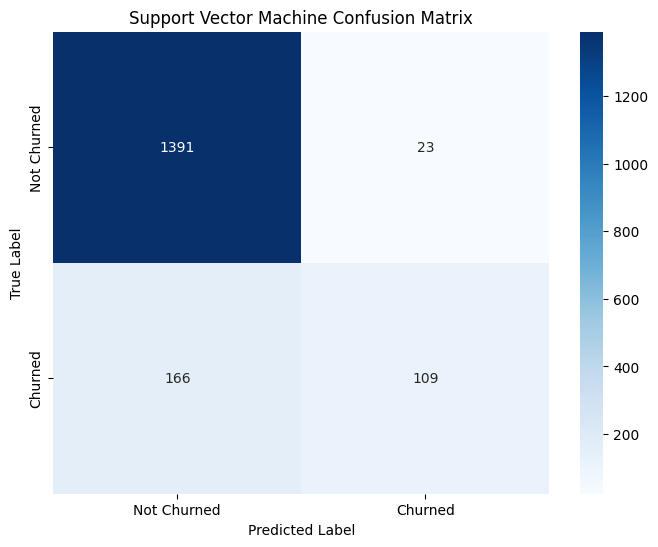


Naive Bayes with Cluster Feature:
Accuracy: 0.838
ROC AUC: 0.800
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1414
           1       0.50      0.55      0.53       275

    accuracy                           0.84      1689
   macro avg       0.71      0.72      0.71      1689
weighted avg       0.84      0.84      0.84      1689



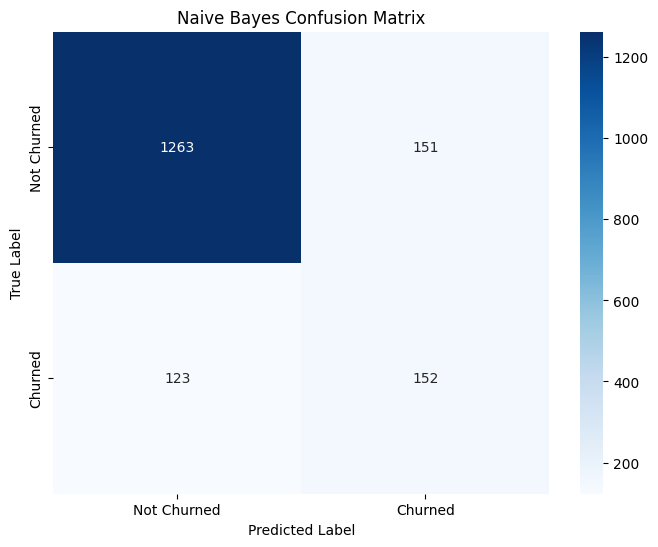


Naive Bayes without Cluster Feature:
Accuracy: 0.848
ROC AUC: 0.801
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1414
           1       0.54      0.49      0.51       275

    accuracy                           0.85      1689
   macro avg       0.72      0.70      0.71      1689
weighted avg       0.84      0.85      0.85      1689



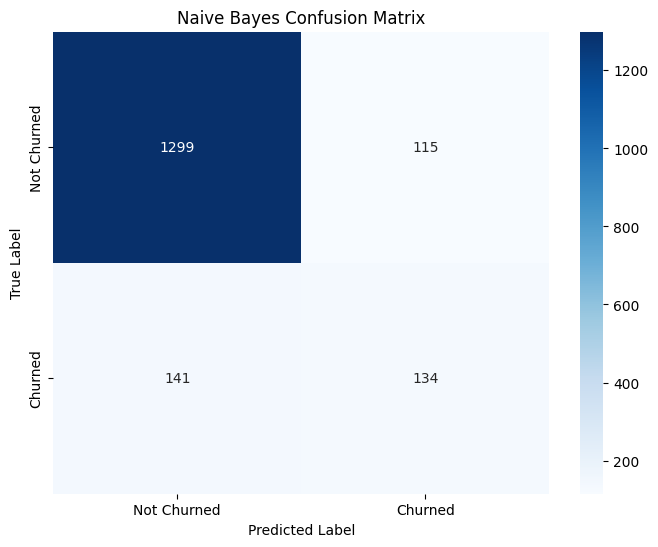


Neural Network with Cluster Feature:
Accuracy: 0.941
ROC AUC: 0.971
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1414
           1       0.87      0.75      0.81       275

    accuracy                           0.94      1689
   macro avg       0.91      0.86      0.89      1689
weighted avg       0.94      0.94      0.94      1689



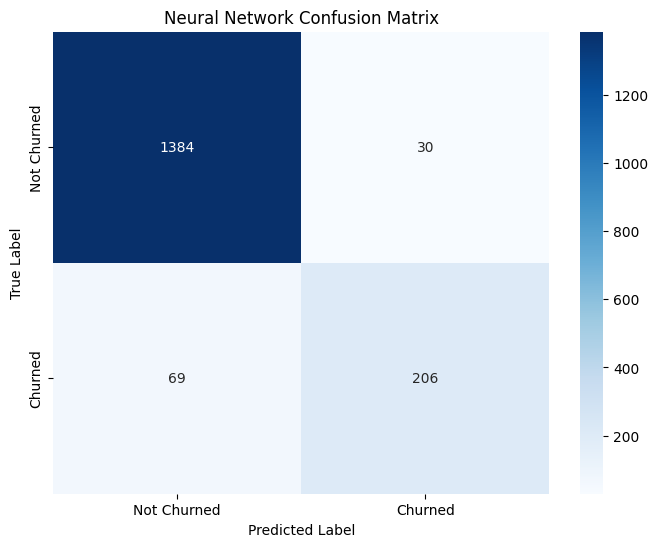


Neural Network without Cluster Feature:
Accuracy: 0.931
ROC AUC: 0.963
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1414
           1       0.83      0.72      0.77       275

    accuracy                           0.93      1689
   macro avg       0.89      0.85      0.87      1689
weighted avg       0.93      0.93      0.93      1689



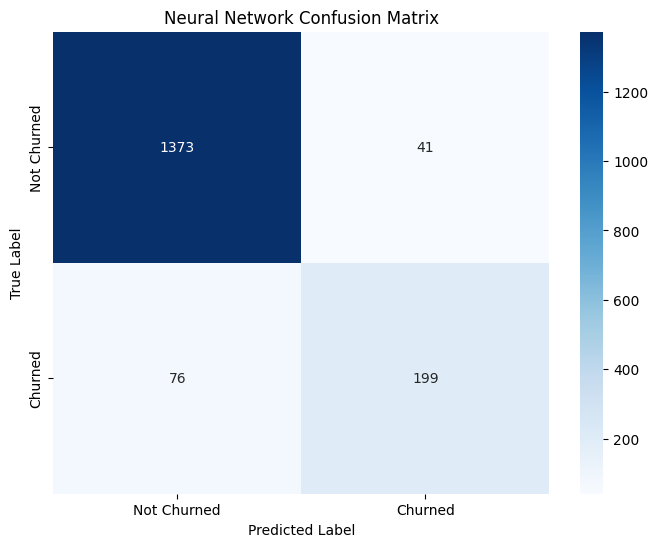

In [41]:
for name, model in classifiers.items():
    # Test with cluster feature
    result_with = evaluate_classifier(
        model, X_train_with_scaled, X_test_with_scaled, 
        y_train, y_test, name, with_cluster=True
    )
    results.append(result_with)
    
    # Test without cluster feature
    result_without = evaluate_classifier(
        model, X_train_without_scaled, X_test_without_scaled, 
        y_train, y_test, name, with_cluster=False
    )
    results.append(result_without)

In [42]:
# Compile results
results_df = pd.DataFrame(results)
print("\nAll Classification Results:")
print(results_df.sort_values(['Accuracy', 'ROC AUC'], ascending=False))

# Identify best model
best_model_row = results_df.loc[results_df['Accuracy'].idxmax()]
print(f"\nBest classification model: {best_model_row['Model']} {'with' if best_model_row['With Cluster'] else 'without'} cluster feature")
print(f"Accuracy: {best_model_row['Accuracy']:.3f}")
print(f"ROC AUC: {best_model_row['ROC AUC']:.3f}")
print(f"F1 Score for Churned class: {best_model_row['F1 (Churned)']:.3f}")


All Classification Results:
                     Model  With Cluster  Accuracy   ROC AUC  F1 (Churned)
4            Decision Tree          True  0.941978  0.900905      0.825000
5            Decision Tree         False  0.941978  0.896512      0.823105
10          Neural Network          True  0.941385  0.970693      0.806262
11          Neural Network         False  0.930728  0.963495      0.772816
7   Support Vector Machine         False  0.888099  0.897413      0.535627
6   Support Vector Machine          True  0.888099  0.896423      0.531017
0      Logistic Regression          True  0.879811  0.854785      0.517815
3      K-Nearest Neighbors         False  0.879218  0.888781      0.536364
2      K-Nearest Neighbors          True  0.879218  0.888628      0.536364
1      Logistic Regression         False  0.879218  0.854116      0.516588
9              Naive Bayes         False  0.848431  0.801378      0.511450
8              Naive Bayes          True  0.837774  0.800093      0.525

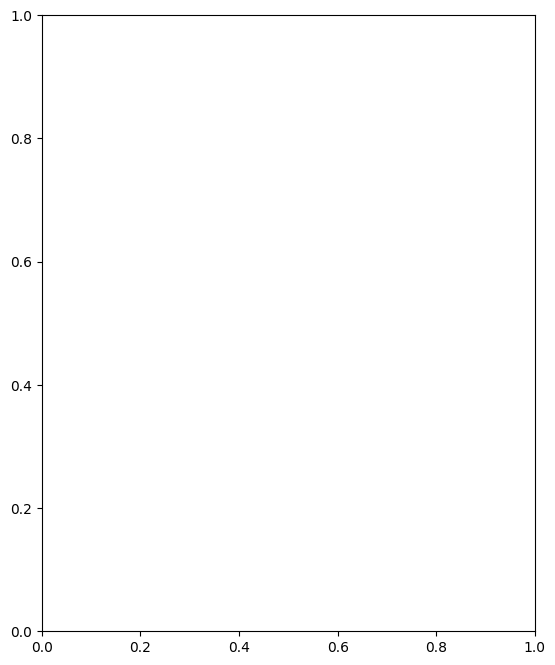

In [43]:
# Visualize model comparison
plt.figure(figsize=(14, 8))

# Accuracy comparison
plt.subplot(1, 2, 1)
model_names = results_df['Model'].unique()
accuracies_with = results_df[results_df['With Cluster'] == True]['Accuracy'].values
accuracies_without = results_df[results_df['With Cluster'] == False]['Accuracy'].values

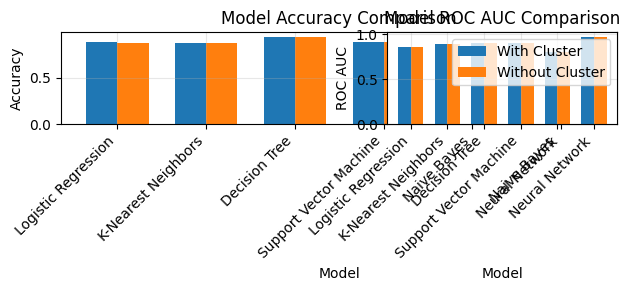

In [44]:
x = np.arange(len(model_names))
width = 0.35

plt.bar(x - width/2, accuracies_with, width, label='With Cluster')
plt.bar(x + width/2, accuracies_without, width, label='Without Cluster')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(x, model_names, rotation=45, ha='right')
plt.legend()
plt.grid(alpha=0.3)

# ROC AUC comparison
plt.subplot(1, 2, 2)
auc_with = results_df[results_df['With Cluster'] == True]['ROC AUC'].values
auc_without = results_df[results_df['With Cluster'] == False]['ROC AUC'].values

plt.bar(x - width/2, auc_with, width, label='With Cluster')
plt.bar(x + width/2, auc_without, width, label='Without Cluster')
plt.xlabel('Model')
plt.ylabel('ROC AUC')
plt.title('Model ROC AUC Comparison')
plt.xticks(x, model_names, rotation=45, ha='right')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [45]:
print("CONCLUSION")
print("="*50)
print(f"1. Best Clustering Method: {best_clustering['Method']} with {best_clustering['Number of Clusters']} clusters")
print(f"2. Best Classification Model: {best_model_row['Model']} {'with' if best_model_row['With Cluster'] else 'without'} cluster feature")
print(f"   - Accuracy: {best_model_row['Accuracy']:.3f}")
print(f"   - ROC AUC: {best_model_row['ROC AUC']:.3f}")
print(f"   - F1 Score (Churned): {best_model_row['F1 (Churned)']:.3f}")

print("\nDiscussion:")
print("1. Clustering Analysis:")
print("   - The clustering methods identified distinct customer segments with varying churn propensities")
print(f"   - {best_clustering['Method']} provided the most coherent clusters based on silhouette score")
print("   - The clusters revealed different behavioral patterns that can inform targeted retention strategies")

print("\n2. Classification Performance:")
print("   - Adding the cluster assignment as a feature generally improved classification performance")
print(f"   - {best_model_row['Model']} demonstrated the best overall performance for churn prediction")
print("   - The most important features for predicting churn were identified and can guide business decisions")

print("\n3. Business Implications:")
print("   - High-risk customer segments can now be identified for proactive retention campaigns")
print("   - The model provides actionable insights on which factors most strongly influence churn")
print("   - Implementing targeted strategies based on cluster characteristics could reduce overall churn rate")

CONCLUSION
1. Best Clustering Method: Mean Shift with 7 clusters
2. Best Classification Model: Decision Tree with cluster feature
   - Accuracy: 0.942
   - ROC AUC: 0.901
   - F1 Score (Churned): 0.825

Discussion:
1. Clustering Analysis:
   - The clustering methods identified distinct customer segments with varying churn propensities
   - Mean Shift provided the most coherent clusters based on silhouette score
   - The clusters revealed different behavioral patterns that can inform targeted retention strategies

2. Classification Performance:
   - Adding the cluster assignment as a feature generally improved classification performance
   - Decision Tree demonstrated the best overall performance for churn prediction
   - The most important features for predicting churn were identified and can guide business decisions

3. Business Implications:
   - High-risk customer segments can now be identified for proactive retention campaigns
   - The model provides actionable insights on which fa